# HW3: Dataset Overview and Use Case Examples
## EDS 220, Fall 2021

## Informing Oil Spill Impacts with High Frequency Radar Surface Current Data
### U.S. West Coast, 6km, hourly

### Authors
- Elmera Azadpour, UC Santa Barbara, 2nd Year MESM
- Ian Brunjes, UC Santa Barbara, 2nd Year MESM
- Phillip Puettmann, UC Santa Barbara, 2nd Year Information Systems (Germany)
- Quin Smith, UC Santa Barbara, 2nd Year MESM

## Table of Contents

[1. Purpose](#purpose)

[2. Dataset Description](#overview)

[3. Data I/O](#io)

[4. Metadata Display and Basic Visualization](#display)

[5. Use Case Examples](#usecases)

[6. Create Binder Environment](#binder)

[7. References](#references)

<a id='purpose'></a> 
### Notebook Purpose

The purpose of this notebook is to provide an introduction to using high frequency radar data from the Integrated Ocean Observing System network/HFRadar network (HFRnet) to derive surface current velocity and direction in the Huntington Beach area during the recent oil spill.

HF radar data are land-based radar systems that use radio waves to measure the speed and direction of ocean surface currents in near real-time. These radar systems can measure the top 1-2 meter of water column from a range of 200 km away from shore. There is a network of 62 HF radars that contribute to the regional data for the California coast, with resolutions ranging from 500 m to 6 km depending on radar frequency. Specifically, this notebook will explore 6 km resolution (hourly) high frequency (HF) radar data of surface currents from the Scripps Institute of Oceanography, University of California San Diego, for analysis of the 2021 oil spill off the coast of Huntington Beach, CA.

<a id='overview'></a> 
### Dataset Description

There are two datasets being used in this exercise:

#### 1. HFRadar Network, U.S. West Coast

This dataset was created by the Coastal Observing Research and Development Center at Scripps Institution of Oceanography, UCSD. The [ HF radar Thredds data server](https://hfrnet-tds.ucsd.edu/thredds/catalog.html) contains near real-time measurements of velocity (RTV) across the Gulf of Alaska, US East and Gulf Coast, Hawai'i, Puerto Rico and Virgin Islands, and US West Coast. The server contains data across hourly, 25hr average, monthly average and annual average RTV. For our purposes, we will download US West Coast 6 km resolution, hourly data in netCDF format. To retrieve this data, we have pulled from the Thredds server using OPeNDAP and xarray.

Upon early data exploration, we noticed the 6 km hourly data does not have complete coverage across the time series and contains spatial incompleteness (NaNs). However, the dataset contains metadata with information regarding data format (datetime64) and geospatial coordinate information (WGS84, Degrees N & E). For our analysis, we have focused on the time frame October 4th, 2021 - October 7th, 2021 to analyze RTV measurements from the recent oil spill off the coast of Huntington Beach, CA.

<div>
<center>
<img src="https://prod-erma-api.orr.noaa.gov/api/v1/data_layer_file/12964/download/" width="800"/>
<br>
Fig. 1: Example Sentinel Satellite Imagery with suspected oil annotations
<br>
Source: https://prod-erma-api.orr.noaa.gov/api/v1/data_layer_file/12964/download/
</center>
</div>
<br>

Apart from the aforementioned data gaps within the spatial and temporal dimensions, we face some minor variations in data quality due to the physical circumstances at the time of measurement: 
The HF radar transmissions for example are subject to interferences. As a matter of fact, the added noise in busy wavelength channels affect data accuracy and also the current operation range of the radars. You can check on these data (and much more) at the public sites' diagnostics pages (e.g. https://hfrnet.ucsd.edu/diagnostics/?p=sta&t=0&sta=COP1 for Coal Oil Point). This gives you some indicators of operational data quality.

<div>
<center>
<img src="https://github.com/fullbeats/EDS220-SeaSurfaceCurrents/blob/main/img/HFsitecoverage.png?raw=1" width="800"/>
<br>
Fig. 2: HF site spatial coverage for Coal Oil Point
<br>
Source: https://hfrnet.ucsd.edu/diagnostics/?p=sta&t=0&sta=COP1
</center>
</div>
<br>

<div>
<center>
<img src="https://github.com/fullbeats/EDS220-SeaSurfaceCurrents/blob/main/img/HFsiterange.png?raw=1" width="800"/>
<br>
Fig. 3: HFR radio wave transmission range over time for Coal Oil Point
<br>
Source: https://hfrnet.ucsd.edu/diagnostics/?p=sta&t=0&sta=COP1
</center>
</div>
<br>
    
#### 2. NESDIS Marine Pollution Surveillance Reports, Suspected Oil (Huntington Beach Oil Spill)
    
Later on, we want to add the actual oil blob movements over time to the plot. We are retrieving this data from a different data source. The data is available from the [Environmental Response Management Application (ERMA)](https://erma.noaa.gov/southwest), which is a web-based Geographic Information System (GIS) tool that assists in dealing with incidents that may adversely impact the environment. ERMA is a project by the NOAA Office of Response and Restauration. Within ERMA, multiple reports are accessible. We want to focus on the NESDIS Marine Pollution Surveillance Reports, which cover data for multiple critical events such as the Huntington Beach spill earlier this year. The data decribes the suspected oil locations and coverages. These results are compiled from satellite data provided by the Copernicus Sentinel mission. Specifically, the [Sentinel-2A/B](https://www.ospo.noaa.gov/Products/ocean/mpsp.html) (ESA/ Copernicus, 10m resolution, 5 or 10 day revisit). Data are either available as images with complete descriptions and annotations, as a layer for an interactive map or available for download. You can see an example of the first one below. However, the data is only available for quite irregular points in time the oil spill took place. This makes it hard to have a stable and ongoing analysis of the movement of the oil.
For further processing in our project, we chose to download the data from the website, extracted the relevant shapefiles and consolidated them to one single set of files (*.shp, *.shx , *.cpg, *.prj and *.dbf file) to the \"shp\" subfolder.

Looking at the data quality of the suspected oil coverages compiled from the Sentinel satellite images we assume that the annotations and actual shapes of the suspected oil were drawn by satellite imagery analysts. They report a confidence level of "medium-high" for that data, which is the second highest value on a four-level scale.


<a id='io'></a> 
### Dataset Input/Output 

In this section, we will read in the data, and ready it for our use case.

In [1]:
#load packages
import contextily as ctx
import geopandas as gpd
import imageio as io
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation

Using xarray to interface with the thredds server, where the data is hosted, we can lazy load the NetCDF file into an xarray object. We are specifically loading the 6km hourly resolution version of the data.

In [2]:
# Using thredds server url and xarray, read in the dataset
url = 'http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd'

ds6km_hr = xr.open_dataset(url)

The dataset inherently is quite large, covering many years and the entire U.S. West Coast. Before we attempt to work with it, we should filter it down to our study area, which covers a general bounding box around Huntington Beach near Los Angeles over the few days that the oil spill occurred.

In [3]:
# Set ROI variables
# ROI bounding box: -119.413147,32.858825,-117.215881,34.064037
x1, y1, x2, y2 = (-119.413147,32.858825,-117.215881,34.064037)
# Start/End date
start_dt, end_dt = ("2021-10-04", "2021-10-07")
# CRS
crs_4326 = 'EPSG:4326'

# Slice data to desired geographic and temporal coverage
ds_hb_spill = ds6km_hr.sel(
    time=slice("2021-10-04", "2021-10-07"),
    lon=slice(x1, x2),
    lat=slice(y1, y2),
    nv=0
)

# Store times in array for later
times = ds_hb_spill.time.to_series()

Checking the size of our subsetted data will give an idea of the valid indeces for each axis, and the number of data points that are present.

In [4]:
# Get dimensions of array
ds_hb_spill.sizes

Frozen({'lat': 22, 'lon': 35, 'time': 96, 'time_1': 1})

The 'time_1' axis is of length 1, and its specification is not necessary. We should remove it now before operating on the data.

In [5]:
# Remove axis with length of 1
ds_hb_spill = ds_hb_spill.squeeze()

<a id='display'></a> 
### Metadata Display and Basic Visualization

Next, let's look at the variables and metadata for our HF data. The netCDF data is stored as an xarray object, which we can read by calling the object's variable name.

In [6]:
# Peak at xarray metadata
ds_hb_spill.head

<bound method Dataset.head of <xarray.Dataset>
Dimensions:                (lat: 22, lon: 35, time: 96)
Coordinates:
  * lat                    (lat) float32 32.89 32.95 33.0 ... 33.92 33.97 34.03
  * lon                    (lon) float32 -119.4 -119.3 -119.2 ... -117.3 -117.2
  * time                   (time) datetime64[ns] 2021-10-04 ... 2021-10-07T23...
    time_run               (time) datetime64[ns] ...
Data variables: (12/14)
    time_bnds              int32 ...
    depth_bnds             float32 ...
    wgs84                  int8 ...
    processing_parameters  int8 ...
    radial_metadata        int8 ...
    depth                  float32 ...
    ...                     ...
    v                      (time, lat, lon) float32 ...
    dopx                   (time, lat, lon) float32 ...
    dopy                   (time, lat, lon) float32 ...
    hdop                   (time, lat, lon) float32 ...
    number_of_sites        (time, lat, lon) float32 ...
    number_of_radials      (tim

The data contains 14 variables:
- time_bnds
- depth_bnds
- wgs84
- processing_parameters
- radial_metadata
- depth
- time_offset
- u
- v
- dopx
- dopy
- hdop
- number_of_sites
- number_of_radials

For our analysis, we are most interested in the vector components (u and v), which will be used to derive velocity and direction of sea surface currents. However, the other variables are also important and worthwhile to explore at a later date. For example, dopx, dopy, and hdop are all measures of "geometric dilution of precision", basically the uncertainty associated with the vector component values. Because the vector components must be derived from at least two radial velocities, one cannot produce completely accurate total vectors as some sets of radial velocities will lie nearly parallel to each other. Dilution of precision occurs at the line joining two backscatter current-mapping HF radars. A detailed description of how the geometric dilution of precision is calculated for HF radar-derived surface currents can be found [here](http://www.codar.com/images/about/2006Barrick_GDOSA.pdf). 

Here is a list of some of the most important variables in the dataset, as specified on the [website](https://hfrnet-tds.ucsd.edu/thredds/catalog/HFR/USWC/6km/hourly/RTV/catalog.html?dataset=HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd):

- dopx = longitudinal dilution of precision
- dopy = latitudinal dilution of precision
- hdop = horizontal dilution of precision
- number_of_radials (count) = number of contributing radials
- number_of_sites (count) = number of contributing radars
- u (m s-1) = surface eastward sea water velocity
- v (m s-1) = surface northward sea water velocity

Additionally, metadata is stored for the data under the 'Attributes' tab of the output.  These include:

- Conventions
- id
- date_created
- source
- program
- title
- summary
- instrument
- keywords
- geospatial_lat_min
- geospatial_lat_max
- geospatial_lon_min
- geospatial_lon_max
- processing_level
- history
- references
- institution
- creator_type
- creator_name
- creator_email
- creator_url
- naming_authority
- standard_name_vocabulary
- keywords_vocabulary
- instrument_vocabulary
- format_version
- product_version 
- _CoordSysBuilder
- cdm_data_type
- featureType
- location

These metadata very helpful in describing the dataset and attributing credit to the various creators and organizations involved. They can be viewed and explored in the above output. But now let's create a preliminary visualization over an arbitrary coordinate to check for obvious data gaps. We'll use lucky number 13 to index both latitude and longitude.

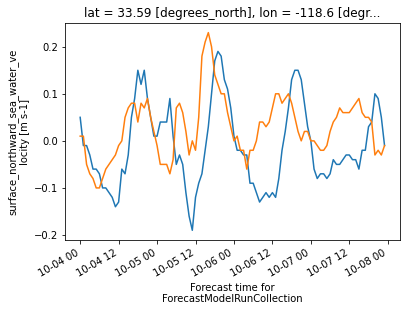

In [7]:
# Plot u & v for a valid coordinate over timespan to check data gaps
single_coord = ds_hb_spill.isel(lat=13, lon=13)
single_coord.u.plot()
single_coord.v.plot()

Our preliminary glance at the data looks pretty good!

The final step of our data prep is to coerce the data into more easily manipulated object types, and clean it up- it inherently has a lot of NaN values, since many of the coordinate pairings within the bounding box fall on land and other areas where HFR surface current readings are not possible.

By casting our xarray first to a dataframe, and then feeding that into a geodataframe, we will be able to utilize geopandas robust spatial plotting and manipulation tools.

In [8]:
# Cast our 3 dimensional xarray to dataframe
df = ds_hb_spill.to_dataframe().reset_index()

# Remove rows with NaN
df = df[-df.isna().any(axis=1)]

# Build a geodataframe using lat lon for geometries and our desired CRS
geo_df = gpd.GeoDataFrame(
    df, 
    geometry = gpd.points_from_xy(df['lon'], df['lat']), 
    crs = crs_4326
)

C:\Users\ianbr\miniconda3\envs\gee\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


<a id='usecases'></a> 
### Use Case Examples

#### Visualizing Surface Currents over Oil Spill Satellite Imagery

For our analysis, we will look at the sea surface currents near Huntington Beach during the 2021 oil spill. We want to determine if patterns in how the "blob" behaved during this period can be correlated with observed sea surface currents. It is crucial for agencies responding to oil spill emergencies to be able to predict how oil will move in real time. Real time data acquistion is important to ensure that resources are spent in a targeted and efficient manner, and that reliable information can be shared with the public to reduce the threat to life and livelihood.

The analysis will demonstrate how to plot "quivers" or directional vectors using matplotlib, manipulation of spatial data via GeoDataFrames, and how to create animated plots and gifs.


Using vector math, we want to find the magnitude of each data point. These values will be used to plot the surface currents.

Given the eastward velocity u, and northward velocity v, we can find the magnitude:

<div>
<center>
<img src="https://github.com/fullbeats/EDS220-SeaSurfaceCurrents/blob/main/img/vectormagnitude.png?raw=1" width="800"/>
<br>
Fig. 4: Finding the magnitude of a vector.
<br>
Source: https://math.lakschool.com/en/themen/vektor/images/vektor_betrag.png
<center>
</div>
<br>

Create a new column in df with the magnitude of our vectors

In [9]:
# Magnitude calculation, based on equation above
geo_df['magnitude'] = np.sqrt(geo_df['u']**2 + geo_df['v']**2)

By default the magnitude of vectors is represented by their length while plotting. Let's see what that looks like, using the built in quivers functionality of matplotlib.

In doing this, we will first want an object to map index with timestamps that are available in our data subset.

In [10]:
# Store the list of timestamps as a series for index mapping
times = ds_hb_spill.time.to_series()

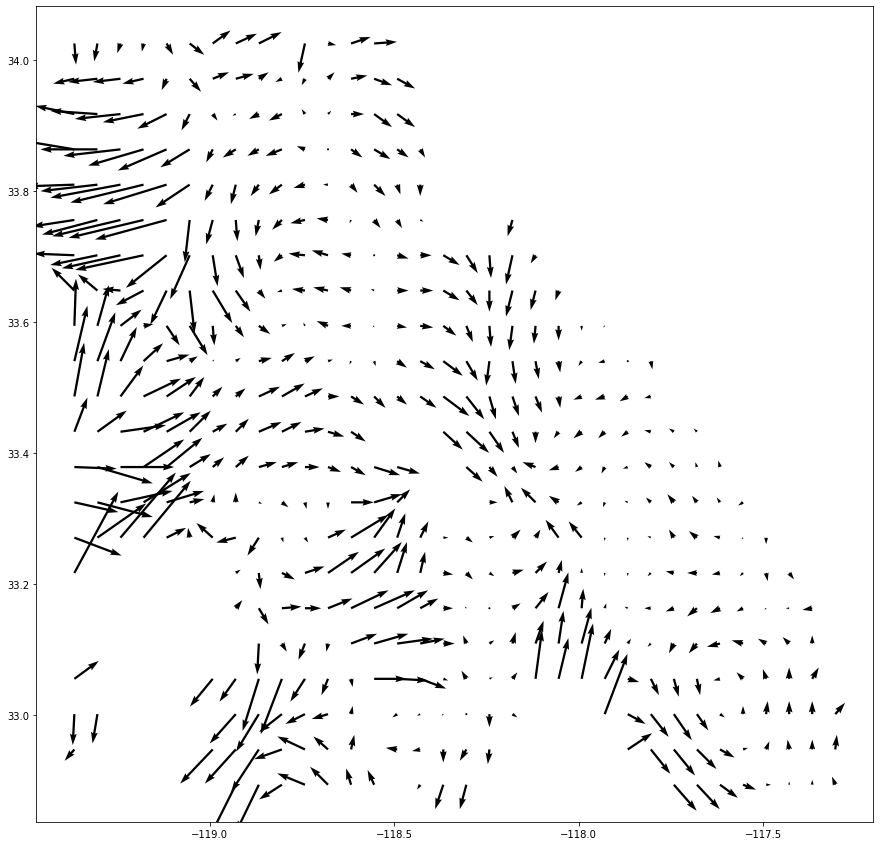

In [11]:
# Create a plot for our data using matplotlib quivers

# Choose an arbitrary time index to plot
t = 95
times[t]

# Subset our data to points at the chosen time
geo_df_t = geo_df[geo_df['time'] == times[t]]

# Initialize plot
fig, ax = plt.subplots(figsize=(15,15))

# Build quivers
ax.quiver(geo_df_t['geometry'].x, 
          geo_df_t['geometry'].y, 
          geo_df_t['u'], 
          geo_df_t['v']
         )

plt.show()

For our visualization, the different length vectors can be hard to read. Let's use a colorscale instead to represent the magnitude using a color scale instead.

The first step for this is to determine a valid range for color scale to represent. Using a histogram to display the distribution of our magnitude values will help us to determine an appropriate range.

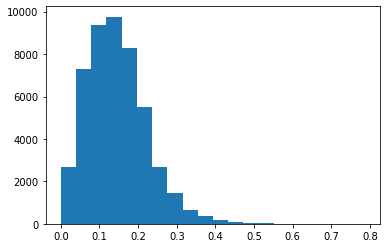

In [12]:
# Look at the histogram from magnitude values to determine
# what range makes sense for the scale
plt.hist(geo_df['magnitude'], bins = 20)
plt.show()

We can set up the python objects we will feed to our plot to represent colors as follows:

In [13]:
# Create a color scale that aligns with range of magnitude values
norm = Normalize(vmin = 0, vmax = 0.4)

# Set color palette
colormap = cm.plasma

# Add color bar
scalarmappaple = cm.ScalarMappable(norm=norm, cmap=colormap)
scalarmappaple.set_array(np.arange(0,0.4, 0.1))

Since magnitude will be represented by color now, we do not want the length of our vectors to also express magnitude. If we normalize the u and v vector values against their calculated magnitude, we can instead provide these normalized values to the quiver function to achieve a standardized vector length.

In [14]:
# To normalize the vector length, we can use our calculated magnitude
# Create normalized vectors for plotting
geo_df['u_norm'] = geo_df['u'] / geo_df['magnitude']
geo_df['v_norm'] = geo_df['v'] / geo_df['magnitude']

With all of our input ready to go, we can create a finalized version of our plot.

By packaging the plot setup inside of a function, we can easily call it to output plots at different timestamps. The function will also be used later on for animating with matplotlib.

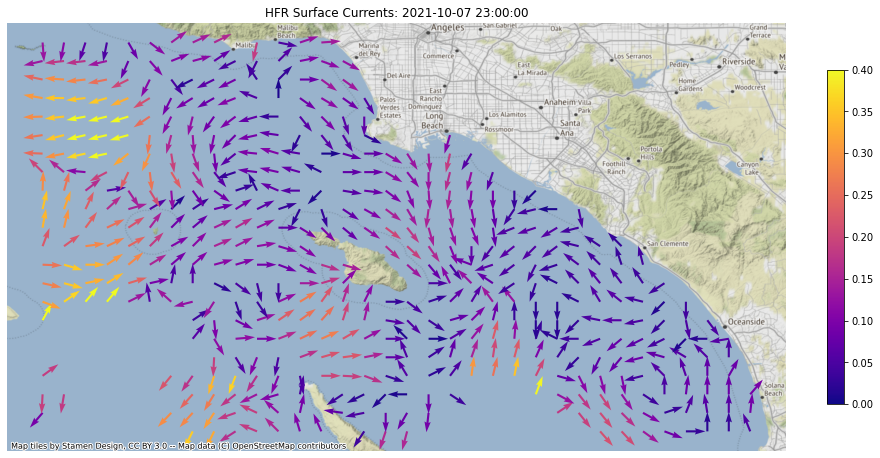

In [15]:
# Now we can formalize the plot by adding our color scale, a basemap, title, and axis formatting

# Setup initial plot with figsize and colorbar
fig, ax = plt.subplots(figsize=(15,9))
plt.colorbar(scalarmappaple, fraction=0.02)

# Build a function to create a plot for a given time index
def plotCurrents(t):
    # Clear current axes
    ax.clear()
    
    # Subset our data to points at the chosen time
    geo_df_t = geo_df[geo_df['time'] == times[t]]

    # Build quivers, using normalized u/v and a color scale
    ax.quiver(
        geo_df_t['geometry'].x,
        geo_df_t['geometry'].y,
        geo_df_t['u_norm'],
        geo_df_t['v_norm'],
        color = colormap(norm(geo_df_t['magnitude']))
    )

    # Add basemap
    ctx.add_basemap(ax, crs = crs_4326, source = ctx.providers.Stamen.Terrain)

    # Additional plot formatting
    ax.set_axis_off()
    ax.set_title('HFR Surface Currents: ' + str(times[t]))
    
plotCurrents(95)    
plt.show()

We're now able to get a nice representation of our surface current vectors.. at a single timestamp.

What we would like to visualize is the change in these currents across our timespan. To do so, we will utilize matplotlibs animated plot functionality, FuncAnimation. Each frame of the animation will be a step through time, which for our data is in one hour increments.

<IPython.core.display.Javascript object>


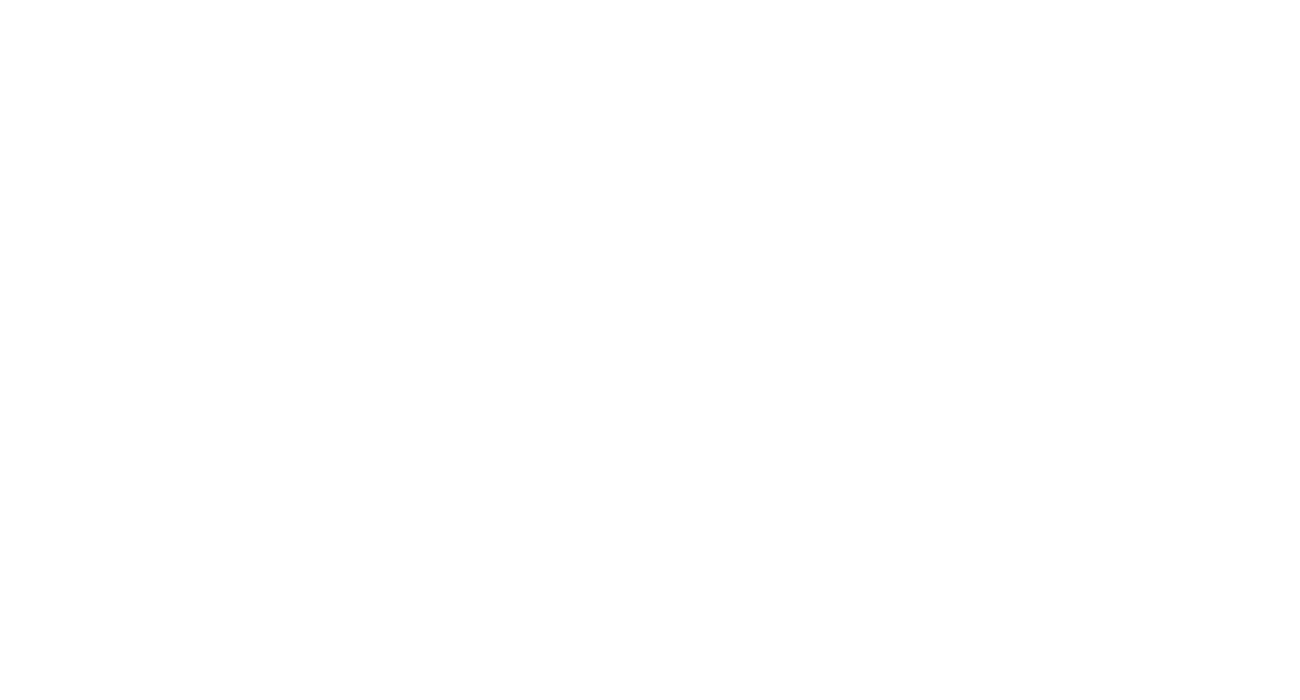

In [16]:
# inline plots for jupyter notebook don't support animation, need to switch plot output to use notebook backend
%matplotlib notebook

# Set up initial plot with figsize and color bar
fig, ax = plt.subplots(figsize=(13,7))
plt.colorbar(scalarmappaple, fraction=0.02)

# Now we can invoke the animation function
# The number of frames = number of indexes in our timespan
ani = FuncAnimation(fig, plotCurrents, interval=200, frames=times.size, repeat=True)
plt.show()

With the surface currents visualized, we now would like to add in an extra layer: the oil spill!

Satellite imagery of the ocean surface, taken over the few days of the oil spill, reveal the extent and spread of oil through the ocean. The NESDIS Marine Pollution Surveillance Reports provide shapefiles of suspected oil that was present in the satellite images.

We can read in the shapefile for the suspected oil, which contains a list of polygons representing suspected oil at a given time.

In [17]:
# Read in oil shape files and format
oil_shapes = gpd.read_file('./shp/suspected_oil_compiled.shp')

# Project to the same CRS as our other data
oil_shapes = oil_shapes.to_crs(4326)

# Convert timestamp to datetime object
oil_shapes['DATETIME'] = pd.to_datetime(oil_shapes['DATETIME'])

We want to enhance our visualization with the suspected oil blobs present on the ocean surface, with the most updated imagery being added as we step through time.

While the we want the outcome to be similar as above, an animated plot stepping through each hour, we will take a different approach to building it- this time using imageio to generate a .gif file that we could email to our moms to show how cool our grad program is.

Note: if using binder, this code will likely cause an out of memory exception.

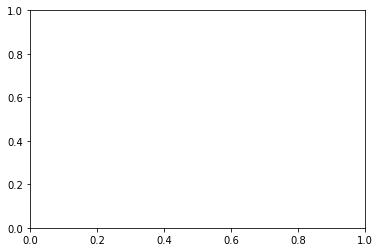

In [18]:
# Create a gif using a series of saved images

# Reset matplotlib to inline
%matplotlib inline

# Rather than a plot that continuously updates as it iterates through each frame
# we will store each individual frame as an image to combine later into a gif
images = []

# Build the plot for each frame of data in our time series
for frame in range(0,times.size):
    # First clear out any existing plot objects
    plt.cla()
    
    # Then build the individual plot for this timestamp
    fig, ax = plt.subplots(figsize=(15,15))

    # Subset our surface current data to points at the chosen time
    geo_df_t = geo_df[geo_df['time'] == times[frame]]

    # Call our surface currents plotting function for the given frame
    plotCurrents(frame)
    
    # Subset and plot the oil shapefiles based on if they should be included for the current timestamp
    current_oil = oil_shapes[oil_shapes['DATETIME'] < str(times[frame])]
    if current_oil.size > 0:
        current_oil.plot(ax = ax, color = "black")
    else:
        # If no oil blobs should be shown, plot an invis one so that figure maintains size throughout gif
        oil_shapes.loc[[0],'geometry'].plot(ax = ax, alpha = 0)
    
    # Once the plot is finished, save it to a file
    filename = './images/frame_'+str(frame)+'.png'
    plt.savefig(filename)
    plt.close()
    
    # Store the image file into our array of images, which will contain all of our frames
    images.append(io.imread(filename))

# Create a single gif file that consolidates all images in our array
io.mimsave('./images/oil_spill.gif', images, duration = 0.5)

The results of this exercise provide an important narrative for events such as the Huntington Beach 2021 oil spill. With realtime hourly collection of these surface current data, it becomes clear how such tools can be actively used to plan oil spill response and recovery.

Being just one of many factors that inform oil flow, this analysis could be extended to include other oceanographic and atmospheric variables, and be shifted into a more formal modeling approach that could be utilized for making predictions on what areas will be affected by an oil spill, before it actually reaches them.

![OilSpill](images/oil_spill.gif "spill")

<a id='binder'></a> 
### Create Binder Environment

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/fullbeats/EDS220-SeaSurfaceCurrents/HEAD)

<a id='references'></a> 
### References

List relevant references. Here are some additional resources on creating professional, shareable notebooks you may find useful:

1. Vector math and trigonometry resource: https://math.libretexts.org/Bookshelves/Precalculus/Precalculus_(OpenStax)/08%3A_Further_Applications_of_Trigonometry/8.08%3A_Vectors
2. NESDIS Marine Pollution Data Source for Suspected Oil from Satellite Imagery: https://erma.noaa.gov/southwest#/layers=1+48526+48525+48506+48569+48575+48462+48452+48423&x=-118.12634&y=33.47098&z=9.6&panel=layer
3. Background on HFR surface current data for the U.S. West Coast: https://sccoos.org/high-frequency-radar/
4. Thredds server with HF Radar Measurements: https://hfrnet-tds.ucsd.edu/thredds/catalog.html
5. Integrated Ocean Observing System, About HF Radar: https://ioos.noaa.gov/project/hf-radar/
6. Coastal HF radars in the Mid-Atlantic Bight: http://www.codar.com/images/about/2012_Kohut_OceanDynamics.pdf